In [1]:
import sys, os

sys.path.append(os.path.abspath("forStudents"))
sys.path.append(os.path.abspath("Images"))

In [2]:
import numpy as np
from scipy.io import loadmat

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
dataset = loadmat('forStudents/dataset.mat')

In [11]:
type(dataset)

dict

In [56]:
dataset['dataset'][0, 0][0, 0][5]

array([[array(['ADC'], 
      dtype='<U3'),
        array(['Ktrans'], 
      dtype='<U6'),
        array(['Kep'], 
      dtype='<U3'),
        array(['PET'], 
      dtype='<U3'),
        array(['T2'], 
      dtype='<U2')]], dtype=object)

### Dataset description:
- dataset['dataset'].shape = (14, 1)
- e.g: dataset['dataset'][0, 0][0, 0][0-5]:
- Each of 14 dataset which last index:
    - 0: Image (4-D double)
    - 1: LabelsA (3D double)
    - 2: LabelsB (3D double)
    - 3: labelsHisto (array)
    - 4: patientIdx (id of patient, int)
    - 5: featureList (1x5 cell, include: T2, ADC, Ktrans, Kep, PET)

### The medical Dataset
- Each of the 14 consists of 5 different 3D images derived from Positron Emission Tomography (PET) and from Magnetic Resonance Tomography (MRT).
- Each of those images represents a cubic around the prostate of the patient. Each of the 2D images at a fixed z-coordinate are referred as slices:
<img src='Images/cancer/1_3D_image.JPG' width='300'>
- Each patient has different size of images, vary from 34x41x31 and 320x320x43 pixels per image.
- For each patient $k$, the dimensions $d_k = (l_k, m_k, n_k)$ of all 5 3D images are equal.
- Each image contains 35000 3D pixels.
- The images are:
    - T2 weighted MR image
    - Apparent diffusion coefficient (ADC) map
    - $K_{trans}$ map
    - $K_{ep}$ map
    - PET map
    <img src='Images/cancer/2_image_types.JPG' width='450'>

### T2 weighted MR images
- Structure and composition of the tissue is visualized in T2 weighted MR images.
- Tissue which is rich of waters appears bright in MR images, while the less water as well as fat or bone appear dark.
- Cancer means many cells overlap, so it will not contain much water. Therefore, those cancer cells also have low signal intensity:
<img src='Images/cancer/3_T2_histogram.JPG' width='450'>
- According to the histogram, the 2 peaks at intensity 2e4 and 3.5e4 represent the cancer and non-cancer tissue. However, the separation seems inpractical because the distributions of the intensity cancer and non-cancer shows a significant overlap.

### The apparent diffusion coefficient (ADC)
- ADC map measures the rate of diffusion of liquids through the tissue:
<img src='Images/cancer/4_ADC.JPG' width='350'>
- For each point, the ADC describes how fast liquids are abel to move in 3 Spatial Directions. 3 rates of diffusion: $D_x(x,y,z)$, $D_y(x,y,z)$ and $D_z(x,y,z)$.
- Absolute rate of diffusion:
$$D(x,y,z)=\sqrt{D_x^2 + D_y^2 + D_z^2}$$
- Rate of diffusion through cancer tissue is slower than in healthy issue. So, cancer cells appear dark, while the healthy ones appear bright:
<img src='Images/cancer/5_ADC_histogram.JPG' width='400'>
- Mean of ADC for healthy tissue: 1300 < $\mu_{ADC}$ < 1600
- Mean value for ADC of cancer tissue is by a factor $c$ lower with 0.4 < $c$ < 0.7.

### Diffusion parameters $K_{trans}$ and $K_{ep}$
- Also describe diffusion rates in the tissues but in different methods. They describe how chemical substances like drugs or contrast agents are brought into and out of those compartments.
<img src='Images/cancer/6_K.JPG' width='400'>
- $K_{trans}$ describes how fast the tracer (chemical substances) moves out of the blood plasma (IES) into the tissue (EES). 
- $K_{ep}$ is the rate of diffusion into the opposite direction and therefore describes how fast the tracer is flushed out of the tissue.
- Diffusion rate is calculated by solving the differential equation:
<img src='Images/cancer/7_K_de.JPG' width='400'>
- where $C_p(t)$ is the concentration of the tracer in plasma 
- $C_t(t)$ is the concentration of the tracer in the blood plasma.
- Higher the concentration $C_p(t)$, faster tracer moves into the tissue. If $C_t(t) - v_pC_p(t)$ is big, the tracer will move fast out of the tissue back into the blood plasma.
- Studies show that both diffusion parameters are **higher** in cancer tissue. Hence, the $k_{trans}$ and $k_{ep}$ map are **bright** in regions of cancer tissue.
- However, the two classes are not separable as shown in histogram:
<img src='Images/cancer/8_K_histogram.JPG' width='400'>

### Positron Emission Tomography (PET) map
- Before measurement, a radioactive substance (tracer) is injected into the patients body. After injection, tracer spreads in the body of the patient and the cells start to accumulate the tracer through their normal metabolism. 
- Then patient will be placed in PET scanner which measures the local radioactivity of the patients tissue.
- High signal intensities = high levels of radiation and are marked red. And they are also cancer tissues.
- Low signal intensities = healthy tissues.
<img src='Images/cancer/9_PET.JPG' width='450'>
<img src='Images/cancer/10_PET_histogram.JPG' width='400'>
- Problem: 
    - Rate the tracer is absorbed in the tissue depends on the level of blood sugar. High level = less tracer is absorbed, so the distribution is shifted to the **left**
    - Rate of absortion depends on the time passed between injection of the tracer and measurement. The measurements are only comparable if time 

### Ground truth (how the tissues are labeled correctly)
- 2 maps composed of manual labels $m_1$ and $m_2$ are available for each patient. They have been created by cancer experts. For patients 12 - 14 (14 patients in total, 1 - 11 used for training, and 12 - 14 for testing), there exists one additional map $m_3$ which is the histological analysis of the prostate.
- $$m_k = \begin{cases} 
      0 & \textrm{non-prostate tissue} \\
      1 & \textrm{healthy prostate tissue} \\
      2 & \textrm{cancer prostate tissue} 
   \end{cases}$$
<img src='Images/cancer/11_labels.JPG' width='400'>
- The expert labels are only trusted if both cancer experts agree. It means in both maps, the labels have to be the same or 0:
$$m_c = \begin{cases} 
    0 & m_1 \neq m_2 \\
    m_1 & m_1 = m_2
\end{cases}$$

### Implementation pipeline
<img src='Images/cancer/12_pipeline.JPG' width='400'>
- Voxel-wise classification: which voxel (cell) is cancer, which is non-cancer.
- Light gray: already been done, dark: to be done

### Extract prostate region:
- Only take prostate tissue regions. The outside should be isolated from the whole dataset. 
- **Task**: implement functions to isolate feature vectors belonging to prostate tissue from the whole dataset. Think of a way to transform a T2 weighted MR image such to make it a usefull feature for classification. This can ,for example, be achieved by scaling the dynamic range of the MR image to the range [0,1].

In [57]:
# Function to isolate prostate region
patients = []
for i in range(0, 14):
    patients.append(dataset['dataset'][i, 0][0, 0])

In [116]:
patients[0][0][:,:,:,0].ndim

3

In [282]:
# Def visualizing images:
def visualize_img(img, feature_no, slice_no):
    assert img.ndim == 4 or img.ndim == 3, 'Input image must be 3D or 4D'
    assert slice_no < img.shape[2], 'z-slice_nr must be less than z-size'
    if img.ndim == 4:
        assert feature_no <= 4, 'Feature number is between 0 - 4'
        img = img[:, :, slice_no, feature_no]
    else:
        img = img[:, :, slice_no]
    plt.imshow(img)
    plt.colorbar()
    
    

In [131]:
def extract_ground_truth(img_a, img_b):
    assert img_a.ndim == 3 and img_b.ndim == 3 and img_a.shape == img_b.shape
    mask = img_a == img_b
    m_c = img_b * mask
    segment_mask = m_c > 0
    return m_c, segment_mask
    

In [132]:
m_c, segment_mask = extract_ground_truth(patients[0][1], patients[0][2])

### Feature normalization
- Feature Scaling is important, so that we can have the same range between the features, even they are obtained by different methods.
- There are some normalization techniques:
    - Scale each dimension of the feature vector to zero mean
    and unit variance:
    $$\tilde{x_k} = \frac{x_k - \mu_k}{\sigma_k}$$
    - Scale each dimension of the feature vector x to unit dynamic range [0, 1]:
    $$\tilde{x_k} = \frac{x_k - min(x_k)}{max(x_k) - min(x_k)}$$
    - Scale the feature vector to unit vector length
    $$\tilde{x} = \frac{x}{||x||}$$

In [273]:
# Transform a feature image to make it useful feature
# by scaling the dynamic range of the image to the range [0, 1]
def feature_scaling(img, method=2):
    assert img.ndim == 3    
    if method == 2:
        # Scale to dynamic range [0, 1]
        max_ = img.max()
        min_ = img.min()
        img = (img - min_) / (max_ - min_)
    elif method == 1:
        # Scale to zero mean and unit variance
        std_deviation = np.std(img)
        mean = np.mean(img)
        img = (img - mean) / std_deviation
    else:
        # Scale the feature vector to unit vector length
        img = img / np.linalg.norm(img)
        
    return img

### Dataset partitioning
- 0 - 10 is for training
- 11 - 13 is for testing
- Only dataset 11 - 13 contain accurate ground truth (labelsHisto)

In [138]:
training_set = patients[:10]

In [150]:
test_set = patients[11:]

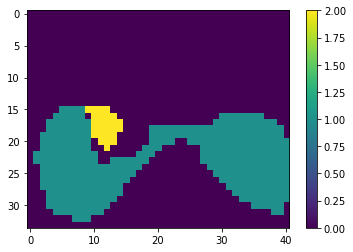

In [294]:
visualize_img(extract_ground_truth(training_set[0][1], training_set[0][2])[0], 50, 22)

In [263]:
def plot_histogram(img, bins=100):
    #assert img.ndim == 3 or img.ndim == 4
    hist, bins_edge= np.histogram(img, bins=bins);
    plt.plot(bins_edge[1:-1], hist[1:], '-')

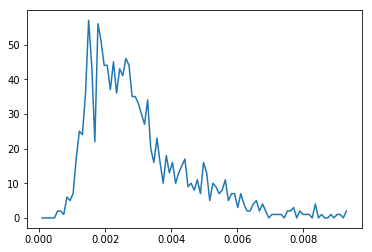

In [275]:
plot_histogram(feature_scaling(patients[0][0][:,:, :, 4], 3)[:,:,3])

### Outlier detection and Removal
- Source: Unmasking Multivariate Outliers and Leverage Points - Peter J.Rousseeuw
- **Outliers:** observations that do not follow the pattern of the majority of the data. It is hard to detect when the dimension *p* exceeds 2, because we cannot rely on visual perception.
- Classical method: compute **Mahalanobis distance** for each point $x_i$:
$$MD_i = \sqrt{(x_i - T(X))C(X)^{-1}(x_i-T(X))^T}$$
- where $T(X)$ is the arithmetic mean of the dataset X

- $C(X)$ is the usual sample covariance matrix.
- Distance $MD_i$: how far $x_i$ is from the center of the cloud, and taking into account the shape of the cloud as well.
- This approach suffers from the masking effect, by which multiple outliers do not necessarily have a large $MD_i$.
<img src='Images/cancer/13_outliers.JPG' width='400'>
- Therefore, we have to have a *robust* estimator ($C(X)$ and $T(X)$ are not robust)

#### Leverage points in regression:
- *leverage points*: cases for which $x_i$ is far away from the bulk of the $x_i$ in the data.
- They occur frequently when $x_i$ are observational, unlike "designed" situations with fixed $x_i$.